In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

In [4]:
GT_captions = pd.read_csv('sorted_captions_val2017.csv')
GT_captions

,image_id,file_name,caption
0,139,000000000139.jpg,A living area with a television and a table
1,139,000000000139.jpg,A person standing at a table in a room.
2,139,000000000139.jpg,A woman stands in the dining area at the table.
3,139,000000000139.jpg,A woman standing in a kitchen by a window
4,139,000000000139.jpg,"A room with chairs, a table, and a woman in it."
...,...,...,...
25009,581781,000000581781.jpg,"A fruit stand that has bananas, papaya, and pl..."
25010,581781,000000581781.jpg,A fruit stand display with bananas and kiwi
25011,581781,000000581781.jpg,A group of bananas surround a small display of...
25012,581781,000000581781.jpg,"A fruit stand with plantains, kiwis, and banan..."


In [5]:
PT_captions = pd.read_csv('generated_captions_model.csv', sep=',')
PT_captions

,image_file,caption
0,000000080057.jpg,A brown teddy bear sitting next to a wooden toy.
1,000000023781.jpg,A table topped with lots of different types of...
2,000000049761.jpg,A herd of wildebeest and zebras grazing in a f...
3,000000017436.jpg,A black and white photo of a man sitting on a ...
4,000000062353.jpg,A group of giraffe standing next to each other.
...,...,...
995,000000108495.jpg,A woman sitting on a skateboard on a sidewalk.
996,000000012667.jpg,A banana sitting on a phone on a desk.
997,000000037751.jpg,A person riding a motorcycle on a dirt road.
998,000000027932.jpg,A baseball mitt and hat sitting on the ground.


In [6]:
model = SentenceTransformer('all-MiniLM-L6-v2') 

In [7]:
sim_scores = []
for _, pt_row in tqdm(PT_captions.iterrows(), total=len(PT_captions)):
    img = pt_row.image_file
    pt_caption = pt_row.caption
    gt_captions = GT_captions[GT_captions['file_name']==img]['caption'].to_list()

    pred_emb = model.encode(pt_caption, convert_to_tensor=True)
    gt_embs = model.encode(gt_captions, convert_to_tensor=True)

    cosine_scores = util.cos_sim(pred_emb, gt_embs)[0] 

    sim_scores.append([img,cosine_scores.max().item()])

100%|██████████| 1000/1000 [00:37<00:00, 26.68it/s]


In [12]:
sim_scores = np.array(sim_scores)

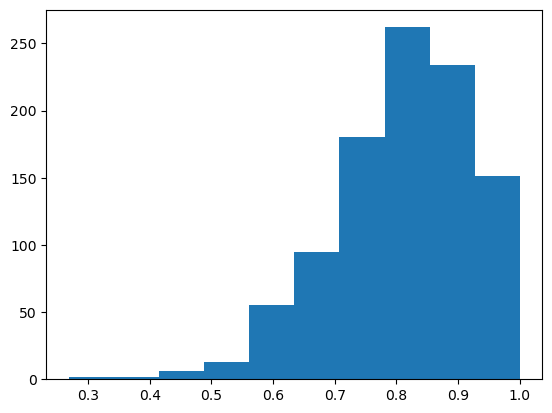

In [16]:
plt.hist(sim_scores[:,1].astype(float))
plt.show()

In [19]:
scores= sim_scores[:,1].astype(float)

In [33]:
thd = [0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
def print_sim_score(scores, threshold= thd, total=1000):
    for threshold in thd:
        accuracy = np.sum(scores > threshold) / total
        print(f"At similarity threshold {threshold}: { accuracy:.3f}")

In [34]:
print_sim_score(scores,0.8, total = 1000)

At similarity threshold 0.5: 0.990
At similarity threshold 0.6: 0.957
At similarity threshold 0.7: 0.836
At similarity threshold 0.75: 0.732
At similarity threshold 0.8: 0.587
At similarity threshold 0.9: 0.219


In [35]:
sim_df = pd.DataFrame(sim_scores,columns=["image_name","score"])
sim_df

,image_name,score
0,000000080057.jpg,0.8930423855781555
1,000000023781.jpg,0.6260303258895874
2,000000049761.jpg,0.8418809175491333
3,000000017436.jpg,0.6928191184997559
4,000000062353.jpg,0.7625905871391296
...,...,...
995,000000108495.jpg,0.8173618316650391
996,000000012667.jpg,0.8602560758590698
997,000000037751.jpg,0.8415665030479431
998,000000027932.jpg,0.8406329154968262


In [52]:
low_sim_images = sim_df[sim_df['score'] <= "0.600"]['image_name'].tolist()
df_low_sim = pd.DataFrame(low_sim_images, columns=['image'])
df_low_sim.to_csv("low_similarity_images_0.6.csv", index=False)